In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("AQI_part1.ipynb")

# Final Project Part 1: Air Quality Dataset
## Analyzing and Predicting AQI Data through Modeling
## Due Date: Wednesday, November 17th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.

## This Assignment

In this final project, we will investigate AQI data for the year 2020 from **USA EPA** data. All the data used for this project can be accessed from the [EPA Website](https://aqs.epa.gov/aqsweb/airdata/download_files.html), which we will pull from directly in this notebook. This dataset contains geographical and time-series data on various factors that contribute to AQI from all government sites. The main goal at the end for you will be to understand how AQI varies both geographically and over time, and use your analysis (as well as other data that you can find) to be predict AQI at a certain point in time for various locations in California.

Through this final project, you will demonstrate your experience with:
* EDA and merging on location using Pandas
* Unsupervised and supervised learning techniques
* Visualization and interpolation

This is **part 1** of the project, which includes the data cleaning, guided EDA and open-ended EDA components of the project. This will help you for part 2, where you will be completing the modeling component. 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import geopandas as gpd

import os
import requests, zipfile, io

import warnings
warnings.filterwarnings('ignore')

<br/><br/>

---
## Section 1: Data Cleaning

As mentioned, we will be using the **US EPA** data from the EPA website. Below is a dataframe of the files we will be using for the project. The following two cells will download the data and put it into a dictionary called `epa_data`.

In [3]:
epa_weburl = "https://aqs.epa.gov/aqsweb/airdata/"
epa_filenames = pd.read_csv("data/epa_filenames.csv")
epa_filenames

,name,epa_filename
0,annual_county_aqi,annual_aqi_by_county_2020
1,daily_county_aqi,daily_aqi_by_county_2020
2,daily_ozone,daily_44201_2020
3,daily_so2,daily_42401_2020
4,daily_co,daily_42101_2020
5,daily_no2,daily_42602_2020
6,daily_temp,daily_WIND_2020
7,daily_wind,daily_TEMP_2020
8,aqs_sites,aqs_sites


Below is code that we used to extract the code from the AQI website, which we encourage you to understand! This will pull directly from the website urls and put it into your `data/` folder. 

In [4]:
epa_data = {}
for name, filename in zip(epa_filenames['name'], epa_filenames['epa_filename']):
    path_name = 'data/{}'.format(name)
    if not os.path.isdir(path_name): 
        data_url = '{}{}.zip'.format(epa_weburl, filename)
        req = requests.get(data_url)
        z = zipfile.ZipFile(io.BytesIO(req.content))
        z.extractall(path_name)
    data = pd.read_csv(f'data/{name}/{filename}.csv')
    epa_data[name] = data

Use the below cell to explore each of the datasets, which can be accessed using the keys in the `name` column of `epa_filenames` above. Currently, the cell is viewing the `annual_county_aqi` dataset, but feel free to change it to whichever dataset you want to explore. 

In [5]:
epa_data.get('annual_county_aqi').head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10
0,Alabama,Baldwin,2020,269,250,19,0,0,0,0,74,49,36,0,0,198,0,71,0
1,Alabama,Clay,2020,108,99,9,0,0,0,0,86,49,26,0,0,0,0,108,0
2,Alabama,DeKalb,2020,364,350,14,0,0,0,0,90,45,36,0,0,331,0,33,0
3,Alabama,Elmore,2020,197,197,0,0,0,0,0,47,41,31,0,0,197,0,0,0
4,Alabama,Etowah,2020,278,260,18,0,0,0,0,92,46,34,0,0,204,0,74,0


<!-- BEGIN QUESTION -->

<br/>

### Question 0: Understanding the Data

Notice that for the table `annual_county_aqi`, the 90th percentile AQI is reported as a column. Why would the 90th percentile AQI be useful as opposed to the maximum? What does it mean when the difference between the 90th percentile AQI and Max AQI is very large compared to the difference between the 90th percentile AQI and the median AQI?

<!--
BEGIN QUESTION
name: q0
manual: True
points: 2
-->

We use 90th percentile AQI to prevent extreme outliers from biasing the data. If the difference between the 90th percentile AQI and MAX AQI is very large, then there exists some extreme outliers. 

<!-- END QUESTION -->

<br/>

### Question 1a: Creating Month and Day Columns

In the `daily_county_aqi` table in `epa_data`, add two new columns called `Day` and `Month` that denote the day and month, respectively, of the AQI reading. The day and month should both be reported as an **integer** as opposed to a string (`Jan`, `Feb`, etc.)

hint: `pd.to_datetime` may be useful.

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [6]:
epa_data.get('daily_county_aqi').head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2020-01-01,48,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2020-01-04,13,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2020-01-07,14,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,1,3,2020-01-10,39,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,1,3,2020-01-13,29,Good,PM2.5,01-003-0010,1


In [7]:
daily_county = epa_data.get('daily_county_aqi')
daily_county['Month'] = pd.DatetimeIndex(daily_county['Date']).month
daily_county['Day'] = pd.DatetimeIndex(daily_county['Date']).day

daily_county.head()
# daily_county.dtypes

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,Month,Day
0,Alabama,Baldwin,1,3,2020-01-01,48,Good,PM2.5,01-003-0010,1,1,1
1,Alabama,Baldwin,1,3,2020-01-04,13,Good,PM2.5,01-003-0010,1,1,4
2,Alabama,Baldwin,1,3,2020-01-07,14,Good,PM2.5,01-003-0010,1,1,7
3,Alabama,Baldwin,1,3,2020-01-10,39,Good,PM2.5,01-003-0010,1,1,10
4,Alabama,Baldwin,1,3,2020-01-13,29,Good,PM2.5,01-003-0010,1,1,13


In [8]:
grader.check("q1a")

q1a results: All test cases passed!

<br/>

### Question 1b: California Data

Currently, `epa_data` contains data for **all** counties in the United States. For the guided part of this project, we are specifically going to be focusing on AQI data for counties in California only. Your task is to assign `epa_data_CA` a dictionary mapping table names to dataframes. This map should have the same contents as `epa_data` but only tables that contain **daily data** in the state of `California`.

<!--
BEGIN QUESTION
name: q1b
points: 3
-->

In [9]:
# epa_data
epa_data.keys()

dict_keys(['annual_county_aqi', 'daily_county_aqi', 'daily_ozone', 'daily_so2', 'daily_co', 'daily_no2', 'daily_temp', 'daily_wind', 'aqs_sites'])

In [10]:
epa_data_CA = {}

names = ['daily_county_aqi', 'daily_ozone', 'daily_so2', 'daily_co', 'daily_no2', 'daily_temp', 'daily_wind']
for name in names:
    df = epa_data.get(name)
    df = df[df['State Name'] == 'California']
    epa_data_CA[name] = df
    
epa_data_CA.get('daily_county_aqi').head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,Month,Day
14003,California,Alameda,6,1,2020-01-01,53,Moderate,PM2.5,06-001-0009,7,1,1
14004,California,Alameda,6,1,2020-01-02,43,Good,PM2.5,06-001-0013,7,1,2
14005,California,Alameda,6,1,2020-01-03,74,Moderate,PM2.5,06-001-0013,7,1,3
14006,California,Alameda,6,1,2020-01-04,45,Good,PM2.5,06-001-0007,7,1,4
14007,California,Alameda,6,1,2020-01-05,33,Good,PM2.5,06-001-0007,7,1,5


In [11]:
grader.check("q1b")

q1b results: All test cases passed!

<br/>

### Question 1c: Merging Site Information

Now take a look at this [link](https://www.epa.gov/outdoor-air-quality-data/about-air-data-reports) and look under "Site ID". For later analysis, we want to first get the latitude and longitudes of each of the measurements in the `daily_county_aqi` table by merging two or more tables in `epa_data_CA` (one of the tables is `daily_county_aqi`).

Our final merged table should be assigned to `epa_data_CA_merged` and the result should contain the following columns: `State Name`, `county Name`, `Month`, `Day`, `AQI`, `Category`, `Defining Site`, `Latitude`, and `Longitude`

<!--
BEGIN QUESTION
name: q1c
points: 4
-->

In [12]:
epa_data.get('aqs_sites').head()

,State Code,County Code,Site Number,Latitude,Longitude,Datum,Elevation,Land Use,Location Setting,Site Established Date,...,Owning Agency,Local Site Name,Address,Zip Code,State Name,County Name,City Name,CBSA Name,Tribe Name,Extraction Date
0,01,1,1,32.437458,-86.472891,WGS84,64.0,RESIDENTIAL,SUBURBAN,1974-05-01,...,Al Dept Of Env Mgt,NaN,"KING ARTHUR TRAILER COURT, PRATTVILLE,AL",36067.0,Alabama,Autauga,Prattville,"Montgomery, AL",NaN,2021-05-18
1,01,1,2,32.428470,-86.443585,WGS84,0.0,AGRICULTURAL,RURAL,1980-01-01,...,Al Dept Of Env Mgt,NaN,COUNTY RD 4 PRATTVILLE EXPERIMENT ST,NaN,Alabama,Autauga,Prattville,"Montgomery, AL",NaN,2021-05-18
2,01,1,3,32.332659,-86.791521,WGS84,41.0,FOREST,RURAL,1989-08-31,...,Al Dept Of Env Mgt,NaN,"1170 COUNTY RD.15 SO., SELMA, AL. 36701",36003.0,Alabama,Autauga,Not in a City,"Montgomery, AL",NaN,2021-05-18
3,01,3,1,0.000000,0.000000,NAD27,0.0,UNKNOWN,RURAL,1959-01-01,...,US EPA National Exposure Research Lab,NaN,CHANDLER RESIDENCE FT MORGAN STATE PARK,NaN,Alabama,Baldwin,Not in a city,"Daphne-Fairhope-Foley, AL",NaN,2021-05-18
4,01,3,2,30.552367,-87.706911,WGS84,0.0,COMMERCIAL,RURAL,1974-01-01,...,Al Dept Of Env Mgt,NaN,COR PENNSYLVANIA & CHICAGO (ROBERTSDALE),36567.0,Alabama,Baldwin,Robertsdale,"Daphne-Fairhope-Foley, AL",NaN,2021-05-18


In [13]:
cols = ['State Name', 'county Name', 'Month', 'Day', 'AQI', 'Category', 'Defining Site', 'Latitude', 'Longitude']
aqs_sites = epa_data.get('aqs_sites')
daily_county_aqi = epa_data_CA.get('daily_county_aqi')

aqs_sites['State ID'] = aqs_sites['State Code'].astype(str).str.zfill(2)
aqs_sites['County ID'] = aqs_sites['County Code'].astype(str).str.zfill(3)
aqs_sites['Site ID'] = aqs_sites['Site Number'].astype(str).str.zfill(4)
aqs_sites['Defining Site'] = aqs_sites['State ID'] + '-' + aqs_sites['County ID'] + '-' + aqs_sites['Site ID']
aqs_sites = aqs_sites[['Latitude', 'Longitude', 'Defining Site']] 
new_df = daily_county_aqi.merge(aqs_sites,  how='left', left_on=['Defining Site'], right_on = ['Defining Site'])
epa_data_CA_merged = new_df[cols]

epa_data_CA_merged.head()

,State Name,county Name,Month,Day,AQI,Category,Defining Site,Latitude,Longitude
0,California,Alameda,1,1,53,Moderate,06-001-0009,37.743065,-122.169935
1,California,Alameda,1,2,43,Good,06-001-0013,37.864767,-122.302741
2,California,Alameda,1,3,74,Moderate,06-001-0013,37.864767,-122.302741
3,California,Alameda,1,4,45,Good,06-001-0007,37.687526,-121.784217
4,California,Alameda,1,5,33,Good,06-001-0007,37.687526,-121.784217


In [14]:
grader.check("q1c")

q1c results: All test cases passed!

<br/>

### Question 2a - Cleaning Traffic Data 

Throughout this project, you will be using other datasets to assist with analysis and predictions. Traditionally, to join dataframes we need to join on a specific column with shared values. However, when it comes to locations, exact latitudes and longitudes are hard to come by since it is a continuous space. First, lets look at such a dataset that we may want to merge on with `epa_data_CA_merged`. 

In the below cell, we have loaded in the `traffic_data` dataset, which contains traffic data for various locations in California. Your task is to clean this table so that it includes only the following columns (you may have to rename some): `District`, `Route`, `County`, `Descriptn`, `AADT`, `Latitude`, `Longitude`, where `AADT` is found by taking the sum of the back and ahead `AADT`s (you may run into some issues with cleaning the data in order to add these columns - `.str` functions may help with this). The metric AADT, annual average daily traffic, is calculated as the sum of the traffic north of the route (ahead AADT) and south of the route (back AADT). You also need to make sure to clean and remove any illegal values from the dataframe (hint: check `Latitude` and `Longitude`).

*Hint:* `str` functions you will likely use: `.strip()`, `.replace()`.

<!--
BEGIN QUESTION
name: q2a
points: 3
-->

In [15]:
# traffic_data = pd.read_csv("data/Traffic_Volumes_AADT.csv")
# traffic_data.head()

In [16]:
traffic_data = pd.read_csv("data/Traffic_Volumes_AADT.csv")
cols = ['District', 'Route', 'County', 'Descriptn', 'AADT', 'Latitude', 'Longitude']

traffic_data_cleaned = pd.DataFrame()
traffic_data_cleaned['District'] = traffic_data['District']
traffic_data_cleaned['Route'] = traffic_data['Route']
traffic_data_cleaned['County'] = traffic_data['County']
traffic_data_cleaned['Descriptn'] = traffic_data['Descriptn']
traffic_data_cleaned['AADT'] = traffic_data['Back_AADT'].str.replace(r'\s', '0').astype(int) + traffic_data['Ahead_AADT'].str.replace(r'\s', '0').astype(int)
traffic_data_cleaned['Latitude'] = traffic_data['Lat_S_or_W']
traffic_data_cleaned['Longitude'] = traffic_data['Lon_S_or_W']

traffic_data_cleaned = traffic_data_cleaned[traffic_data_cleaned['Longitude'] != 'Left Skipped - Input PM on Right Ind. Alignment']
traffic_data_cleaned = traffic_data_cleaned[traffic_data_cleaned['Latitude'] != 'Left Skipped - Input PM on Right Ind. Alignment']

traffic_data_cleaned.head()

,District,Route,County,Descriptn,AADT,Latitude,Longitude
0,1,1,MEN,SONOMA/MENDOCINO COUNTY LINE,4000,38.75984264,-123.5185026
1,1,1,MEN,NORTH LIMITS GUALALA,7100,38.77004592,-123.53189
2,1,1,MEN,FISH ROCK ROAD,6200,38.80354931,-123.585411
3,1,1,MEN,"POINT ARENA, SOUTH CITY LIMITS",4600,38.90397338,-123.6915134
4,1,1,MEN,"POINT ARENA, RIVERSIDE DRIVE",5000,38.91091252,-123.6924099


In [17]:
grader.check("q2a")

q2a results: All test cases passed!

### Question 2b - Merging on Traffic Data 

Traditionally, we could employ some sort of join where we join `epa_data_CA_merged` rows with the row in `traffic_data` that it is the "closest" to, as measured by euclidean distance. As you can imagine, this can be quite tedious so instead we will use a special type of join called a **spatial join**, which can be done using the package `geopandas`, which is imported as `gpd`. The documentation for `geopandas` is linked [here](https://geopandas.org/docs/reference/api/geopandas.sjoin_nearest.html). Please use this as a resource to do the following tasks: 

 - turn `traffic_data_cleaned` and `epa_data_CA_merged` into a geopandas dataframe using the latitude and longitude.
 - Use a spatial join (which function is this in the documentation?) to match the correct traffic row information to each entry in `epa_data_CA_merged`. 

Your final dataframe should be assigned to `gpd_epa_traffic` with the following columns: `State Name`, `county Name`, `Month`, `Day`, `AQI`, `Category`, `Defining Site`, `Site Lat`, `Site Long`, `Traffic Lat`, `Traffic Long`, `Descriptn`, and `AADT`.

<!--
BEGIN QUESTION
name: q2b
points: 2
-->

In [18]:
# traffic_geo = gpd.GeoDataFrame(
#     traffic_data_cleaned, geometry=gpd.points_from_xy(x=traffic_data_cleaned['Longitude'].astype('float') , y=traffic_data_cleaned['Latitude'].astype('float') )
# )


# epa_geo = gpd.GeoDataFrame(
#     epa_data_CA_merged, geometry=gpd.points_from_xy(x=epa_data_CA_merged['Longitude'].astype('float'), y=epa_data_CA_merged['Latitude'].astype('float'))
# )

# cols = ['State Name', 'county Name', 'Month', 'Day', 'AQI', 'Category', 'Defining Site', 'Latitude_right', 'Longitude_right', 'Latitude_left', 'Longitude_left', 'Descriptn', 'AADT']
# gpd_epa_traffic = gpd.sjoin_nearest(traffic_geo, epa_geo)
# gpd_epa_traffic = gpd_epa_traffic[cols]
# # ['Site Lat', 'Site Long', 'Traffic Lat', 'Traffic Long']
# gpd_epa_traffic['Site Lat'] = gpd_epa_traffic[
# gpd_epa_traffic.head()
cols = ['State Name', 'county Name', 'Month', 'Day', 'AQI', 'Category', 'Defining Site', 'Site Lat', 'Site Long', 'Traffic Lat', 'Traffic Long', 'Descriptn', 'AADT']

temp = epa_data_CA_merged.copy()
gdf_epa = gpd.GeoDataFrame(
    temp, geometry=gpd.points_from_xy(temp.Longitude, temp.Latitude))
gdf_epa = gdf_epa.rename(columns = {'Latitude': 'Site Lat', 'Longitude':'Site Long'})

gdf_traffic = gpd.GeoDataFrame(
    traffic_data_cleaned, geometry=gpd.points_from_xy(traffic_data_cleaned.Longitude.astype(float), traffic_data_cleaned.Latitude.astype(float)))
gdf_traffic = gdf_traffic.rename(columns = {'Latitude': 'Traffic Lat', 'Longitude' : 'Traffic Long'})

gpd_epa_traffic = gpd.sjoin_nearest(gdf_epa, gdf_traffic)
gpd_epa_traffic = gpd_epa_traffic[cols]
gpd_epa_traffic['Traffic Long'] = gpd_epa_traffic['Traffic Long'].astype(float)
gpd_epa_traffic['Traffic Lat'] = gpd_epa_traffic['Traffic Lat'].astype(float)
gpd_epa_traffic['Site Long'] = gpd_epa_traffic['Site Long'].astype(float)
gpd_epa_traffic['Site Lat'] = gpd_epa_traffic['Site Lat'].astype(float)
gpd_epa_traffic.head()
# epa_data_CA_merged.head()

,State Name,county Name,Month,Day,AQI,Category,Defining Site,Site Lat,Site Long,Traffic Lat,Traffic Long,Descriptn,AADT
0,California,Alameda,1,1,53,Moderate,06-001-0009,37.743065,-122.169935,37.744352,-122.170586,"OAKLAND, 98TH AVENUE",48300
24,California,Alameda,1,25,40,Good,06-001-0009,37.743065,-122.169935,37.744352,-122.170586,"OAKLAND, 98TH AVENUE",48300
184,California,Alameda,7,3,48,Good,06-001-0009,37.743065,-122.169935,37.744352,-122.170586,"OAKLAND, 98TH AVENUE",48300
185,California,Alameda,7,4,115,Unhealthy for Sensitive Groups,06-001-0009,37.743065,-122.169935,37.744352,-122.170586,"OAKLAND, 98TH AVENUE",48300
186,California,Alameda,7,5,78,Moderate,06-001-0009,37.743065,-122.169935,37.744352,-122.170586,"OAKLAND, 98TH AVENUE",48300


In [19]:
grader.check("q2b")

q2b results: All test cases passed!

<br/><br/>

---
## Section 2: Guided EDA


### Question 3a: Initial AQI Analysis

Assign a `pd.Series` object to `worst_median_aqis` that contains the states with the top 10 worst median AQIs throughout the year 2020, as measured by the average median AQIs across all counties for a single state. Your result should have index `state`, the column value should be labelled `Average Median AQI`, and it should be arranged in descending order.

Now, assign the same thing to `worst_max_aqis`, except instead of aggregating the average median AQIs across all counties, aggregate the average **max AQIs** across all counties. Your result should have the same shape and labels as before, except the column value should be labelled `Average Max AQI`. 

Note: you may have to remove a few regions in your tables. Make sure every entry in your output is a **US State**.

<!--
BEGIN QUESTION
name: q3a
points: 2
-->

In [20]:
# daily_county_aqi = epa_data.get('daily_county_aqi')
# worst_median_aqis = daily_county_aqi.groupby('State Name').agg(np.median).sort_values(by='AQI')['AQI'].head(10)
# worst_max_aqis = daily_county_aqi.groupby('State Name').agg(np.median).sort_values(by='AQI',ascending=False)['AQI'].head(10)

# daily_county_aqi = epa_data.get('daily_county_aqi')
# daily_county_aqi = daily_county_aqi[daily_county_aqi['State Name'] != 'Country Of Mexico']
# result = daily_county_aqi.groupby(['State Name', 'county Name']).median().groupby('State Name').agg(np.mean)['AQI']
# worst_median_aqis = result.sort_values(ascending = False)[0:10]

# print("Worst Median AQI : \n{}\n".format(worst_median_aqis))
# print("Worst Max AQI : \n{}".format(worst_max_aqis))

# np.round(list(worst_max_aqis), 2)

# daily_county_aqi = epa_data.get('daily_county_aqi')
# daily_county_aqi = daily_county_aqi[(daily_county_aqi['State Name'] != 'Country Of Mexico' ) 
#                                     & (daily_county_aqi['State Name'] != 'District Of Columbia') 
#                                     & (daily_county_aqi['State Name'] != 'Puerto Rico')
#                                     & (daily_county_aqi['State Name'] != 'Virgin Islands')]
# result = daily_county_aqi.groupby(['State Name', 'county Name']).median().groupby('State Name').mean()['AQI']
# worst_median_aqis = result.sort_values(ascending = False)[:10]

# result2 = daily_county_aqi.groupby(['State Name', 'county Name']).max().groupby('State Name').mean()['AQI']
# worst_max_aqis = result2.sort_values(ascending = False)[:10]

# print("Worst Median AQI : \n{}\n".format(worst_median_aqis))
# print("Worst Max AQI : \n{}".format(worst_max_aqis))
annual_county_aqi = epa_data.get('annual_county_aqi')
annual_county_aqi = annual_county_aqi[(annual_county_aqi['State'] != 'Country Of Mexico' ) 
                                    & (annual_county_aqi['State'] != 'District Of Columbia') 
                                    & (annual_county_aqi['State'] != 'Puerto Rico')
                                     & (annual_county_aqi['State'] != 'Virginia Island')]

result = annual_county_aqi.groupby('State').mean()['Median AQI']
worst_median_aqis = result.sort_values(ascending = False)[:10]

result2 = annual_county_aqi.groupby('State').mean()['Max AQI']
worst_max_aqis = result2.sort_values(ascending = False)[:10]

print("Worst Median AQI : \n{}\n".format(worst_median_aqis))
print("Worst Max AQI : \n{}".format(worst_max_aqis))

Worst Median AQI : 
State
California       48.018868
Arizona          47.307692
Utah             41.066667
Connecticut      39.125000
Delaware         38.000000
Mississippi      37.200000
New Jersey       36.937500
Massachusetts    36.538462
Nevada           36.222222
Pennsylvania     35.756098
Name: Median AQI, dtype: float64

Worst Max AQI : 
State
Oregon          430.347826
Washington      334.419355
California      286.981132
Arizona         238.230769
Idaho           197.857143
Wyoming         196.666667
Nevada          196.666667
Montana         137.421053
Rhode Island    133.000000
Connecticut     124.750000
Name: Max AQI, dtype: float64


In [21]:
grader.check("q3a")

q3a results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 3b: Worst AQI States

What are the states that are in both of the top 10 lists? Why do you think most of these states are on both of the lists?

<!--
BEGIN QUESTION
name: q3b
manual: True
points: 2
-->

California, Arizona, Connecticut, Nevada. These states have large populations and are more industrialized, making them more heavily polluted. 

<!-- END QUESTION -->

<br/>

### Question 4a: Missing AQI Data

We want to see the accessibility of the AQI data across states. In the following cell, assign `days_with_AQI` to a series that contains the state as the index and the average number of days with AQI entries across all counties in that state as the value. Make sure to label the series as `Days with AQI` and sort in ascending order (smallest average number of days at the top). As before, make sure to remove the regions that are not **US States** from your series.

<!--
BEGIN QUESTION
name: q4a
points: 2
-->

In [22]:
daily_county_aqi = epa_data.get('daily_county_aqi')
daily_county_aqi = daily_county_aqi[(daily_county_aqi['State Name'] != 'Country Of Mexico' ) 
                                    & (daily_county_aqi['State Name'] != 'District Of Columbia') 
                                    & (daily_county_aqi['State Name'] != 'Puerto Rico')
                                    & (daily_county_aqi['State Name'] != 'Virgin Islands')]

days_with_AQI = daily_county_aqi.groupby(['State Name', 'county Name']).count().groupby('State Name').mean()['AQI'].sort_values(ascending = True)

days_with_AQI.head()

State Name
Alaska        235.222222
Arkansas      251.545455
New Mexico    264.062500
Virginia      265.303030
Colorado      278.892857
Name: AQI, dtype: float64

In [23]:
grader.check("q4a")

q4a results: All test cases passed!

<br/>

### Question 4b: What are the missing dates?

In the following cell, we create the series `ca_aqi_days` that outputs a series with each county in California mapped to the number of days that they have AQI data on. Notice that there exists a few counties without the full year of data, which is what you will be taking a closer look at in the following two parts.

In [24]:
ca_annual_data = epa_data.get('annual_county_aqi')[epa_data.get('annual_county_aqi')['State'] == 'California']
ca_aqi_days = ca_annual_data['Days with AQI'].sort_values()
ca_aqi_days.head(10)

54    274
96    331
63    351
98    353
49    359
76    360
51    364
57    364
72    365
79    366
Name: Days with AQI, dtype: int64

#### Question 4bi: Missing Days

Assign `county_to_missing_dates` to a dictionary that maps each county with less than the full year of data to the dates that have missing AQI data. Make sure that your keys are just the county name (no whitespace around it or `, California` appended to it) and the values are of the format `yyyy-mm-dd`.

<!--
BEGIN QUESTION
name: q4i
points: 2
-->

In [25]:
# ca_annual_data.head()
daily_county_aqi.head()
# ca_annual_data[ca_annual_data['Days with AQI'] != 366]['County']
date_366 = daily_county_aqi[daily_county_aqi['county Name'] == 'Alameda']['Date']
date_less = daily_county_aqi[daily_county_aqi['county Name'] == 'Amador']['Date']
date_366[date_366.isin(date_less) == False]

14006    2020-01-04
14007    2020-01-05
14008    2020-01-06
14009    2020-01-07
14239    2020-08-24
14293    2020-10-17
14294    2020-10-18
Name: Date, dtype: object

In [26]:
# county_to_missing_dates = {}
# less_than_366_counties = ca_annual_data[ca_annual_data['Days with AQI'] != 366]['County']

# for county in less_than_366_counties:
#     dates = []
#     curr_date = daily_county_aqi[daily_county_aqi['county Name'] == county]['Date']
#     dates = date_366[date_366.isin(curr_date) == False]
#     county_to_missing_dates[county] = list(dates)

ca_daily = daily_county[daily_county['State Name'] == 'California']
less_than_366 = ca_annual_data[ca_annual_data['Days with AQI'] != 366]['County']
full_year = ca_daily[ca_daily['county Name'] == 'Alameda']['Date']

county_to_missing_dates = {}

for i in less_than_366:
    df = ca_daily[ca_daily['county Name'] == i]['Date']
    result = pd.DataFrame()
    result['full year'] = full_year
    merged = result.merge(df, how = 'left', left_on = ['full year'], right_on = ['Date'])                
    missing = merged[merged['Date'].isnull()]
    missing_list = missing['full year']
    county_to_missing_dates[i] = list(missing_list)

In [27]:
grader.check("q4i")

q4i results: All test cases passed!

<!-- BEGIN QUESTION -->

#### Question 4bii: Missing Days

Are there any key missing dates in common between the counties that have missing AQI data? What two counties have the most missing days and why do you think they do?

<!--
BEGIN QUESTION
name: q4bii
manual: True
points: 2
-->

In [28]:
count_map = {}
for c in county_to_missing_dates:
    for date in county_to_missing_dates.get(c):
        if (date in count_map):
            count_map[date] = count_map.get(date) + 1
        else:
            count_map[date] = 1
    # print(c)
    # print(county_to_missing_dates.get(c))

# for date in count_map:
    # print (date)
    # print (count_map.get(date))

Del Norte and Trinity have the most missing days. It might be due to malfunction of the aqi detectors. There is no common missing dates among the counties. 

<!-- END QUESTION -->



<br/>

### Question 5a: AQI over Time 

Assign `aqi_per_month` to a series of the average aqi per month across all US states and `aqi_per_month_CA` to a series of the average AQI per month across California.

<!--
BEGIN QUESTION
name: q5a
points: 1
-->

In [29]:
aqi_per_month = daily_county.groupby('Month').mean()['AQI']
aqi_per_month_CA = ca_daily.groupby('Month').mean()['AQI']


print("AQI per Month: \n{}\n".format(aqi_per_month))
print("AQI per Month California : \n{}".format(aqi_per_month_CA))

AQI per Month: 
Month
1     31.032050
2     32.258621
3     34.509181
4     37.287264
5     36.273464
6     40.533681
7     40.070404
8     41.252281
9     43.290611
10    35.285558
11    34.184020
12    34.990632
Name: AQI, dtype: float64

AQI per Month California : 
Month
1      46.346888
2      47.110236
3      40.114094
4      41.443462
5      49.538319
6      47.996146
7      56.069375
8      79.960220
9     107.020228
10     75.491763
11     52.070573
12     53.645516
Name: AQI, dtype: float64


In [30]:
grader.check("q5a")

q5a results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 5b: AQI over Time Analysis 

Is there anything interesting that you notice in `aqi_per_month_CA`? If so, why do you think that is?

<!--
BEGIN QUESTION
name: q5b
manual: True
points: 1
-->

In september, the AQI in California is exceptionally high. It's probably due to wildfire in California. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 5c: Modeling AQI over Time

Based on the AQI pattern in the year 2020, if we were to model AQI over the last 10 years, with the average AQI per year being the same, what sort of parametric function $f(x)$ would you use? Let us say that we see a linear increase in the average AQI per year over the last 10 years instead, then what parametric function $g(x)$ would you use?

<!--
BEGIN QUESTION
name: q5c
manual: True
points: 3
-->

If the domain of x is each year in the past 10 years, I would use a constant function to model f(x), and a linear function to model g(x). If x is for each month in the past 10 years, I would use a sine function to model f(x), and a linear and sine function combined, such as sin(x) + x to model g(x).  

<!-- END QUESTION -->



<br/>

### Question 6a: Create Heatmap Buckets

Now we want to create a function called `bucket_data`, which takes in the following parameters: `table`, `resolution`. It outputs a pivot table with the latitude bucket (smallest latitude for that grid point) on the index and the longitude bucket (smallest longitude for that grid point) on the columns. The values in the pivot table should be the average AQI of the monitor sites inside that respective rectangle grid of latitudes and longitudes. The following should be the output of `bucket_data(epa_data_CA_merged, np.mean, 5)`:

<img src="images/q6a.png" width="600px" align="center"/>

epa_data_CA_mergedepa_data_CA_mergedThe `resolution` parameter describes the number of buckets that the latitudes and longitudes are divided into on the heatmap. As an example, let us say that the range of longitudes for site monitors are between \[100, 110\]; make sure that the start of the range is exactly the **minimum** of all longitude values of your site monitors and the end of the range is the exactly the **maximum** of all longitude values of your site monitors. Let us say that we have a resolution of 10. Then we have the buckets 
$$([100, 101], [101, 102], ..., [109, 110])$$

The column and row labels of this dataframe should be labelled as the **start** of the bucket. In the case of the example above, the names of the buckets should be $ 100, 101, \dots 109 $. Note that we are just looking at the longitude dimension in this example, and you have to do do the same for the latitude dimension along the rows in order to build the pivot table.

Finally, make sure the row and column labels of your pivot table are **exactly** the same as the example given above. 
<!--
BEGIN QUESTION
name: q6a
points: 6
-->

In [31]:
def helper(interval, list):
    result = [0] * len(list)
    for i in range(len(list)):
        for val in interval:
            if list.iloc[i] >= val:
                result[i] = np.round(val, 2)
    return result

def bucket_data(table, aggfunc, resolution):
    lat_bucket = np.linspace(table['Latitude'].min(), table['Latitude'].max(), num=resolution, endpoint=False)
    long_bucket = np.linspace(table['Longitude'].min(), table['Longitude'].max(), num=resolution, endpoint=False)
    temp = table.copy()
    temp['lat_bucket'] = helper(lat_bucket, table['Latitude'])
    temp['long_bucket'] = helper(long_bucket, table['Longitude'])
    pivot_cols = ['lat_bucket', 'long_bucket', 'AQI']
    temp = temp[pivot_cols]
    pivot_table = pd.pivot_table(temp, index='lat_bucket', columns='long_bucket', aggfunc=aggfunc)
    return pivot_table


bucket_data(epa_data_CA_merged, np.mean, 5)


# def bucket_data(table, aggfunc, resolution):
#     lat_bucket = np.linspace(table['Latitude'].min(), table['Latitude'].max(), num=resolution, endpoint=True)
#     long_bucket = np.linspace(table['Longitude'].min(), table['Longitude'].max(), num=resolution, endpoint=True)
#     temp = table
#     temp['lat_bucket'] = pd.cut(temp['Latitude'], bins=np.round(lat_bucket, 2), right = False)
#     temp['long_bucket'] = pd.cut(temp['Longitude'], bins=np.round(long_bucket, 2), right = False)
#     pivot_table = pd.pivot_table(temp, values='AQI', columns='long_bucket', index='lat_bucket', aggfunc=aggfunc)
#     return pivot_table

# bucket_data(epa_data_CA_merged, np.mean, 5)

AQI                                            
long_bucket    -124.20    -122.28    -120.36    -118.44    -116.52
lat_bucket                                                        
32.58              NaN        NaN  65.317391  87.059645  67.955508
34.41              NaN  50.221983  67.597970  74.442308  58.294118
36.25        42.792276  51.489882  81.094254  74.704918        NaN
38.08        38.934803  53.699484  48.977778        NaN        NaN
39.92        38.790792  55.207065        NaN        NaN        NaN

In [32]:
grader.check("q6a")

q6a results:
    q6a - 1 result:
        Trying:
            np.round(bucket_data(epa_data_CA_merged, np.median, 5).iloc[:, 0].loc[39.46], 2) == 38
        Expecting:
            True
        **********************************************************************
        Line 1, in q6a 0
        Failed example:
            np.round(bucket_data(epa_data_CA_merged, np.median, 5).iloc[:, 0].loc[39.46], 2) == 38
        Exception raised:
            Traceback (most recent call last):
              File "/opt/conda/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3361, in get_loc
                return self._engine.get_loc(casted_key)
              File "pandas/_libs/index.pyx", line 76, in pandas._libs.index.IndexEngine.get_loc
              File "pandas/_libs/index.pyx", line 108, in pandas._libs.index.IndexEngine.get_loc
              File "pandas/_libs/hashtable_class_helper.pxi", line 1533, in pandas._libs.hashtable.Float64HashTable.get_item
              File "pandas/_libs/hashtable_class_helper.pxi", line 1542, in pandas._libs.hashtable.Float64HashTable.get_item
            KeyError: 39.46

            The above exception was the direct cause of the following exception:

            Traceback (most recent call last):
              File "/opt/conda/lib/python3.9/doctest.py", line 1336, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q6a 0[0]>", line 1, in <module>
                np.round(bucket_data(epa_data_CA_merged, np.median, 5).iloc[:, 0].loc[39.46], 2) == 38
              File "/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py", line 931, in __getitem__
                return self._getitem_axis(maybe_callable, axis=axis)
              File "/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py", line 1164, in _getitem_axis
                return self._get_label(key, axis=axis)
              File "/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py", line 1113, in _get_label
                return self.obj.xs(label, axis=axis)
              File "/opt/conda/lib/python3.9/site-packages/pandas/core/generic.py", line 3776, in xs
                loc = index.get_loc(key)
              File "/opt/conda/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3363, in get_loc
                raise KeyError(key) from err
            KeyError: 39.46

<br/>

### Question 6b: Visualize Heatmap

Assign `heatmap_data` to a heatmap bucket pivot table aggregated by median with resolution 30 for California AQI for the month of september. The code in the following cell will plot this heatmap for you. 

<!--
BEGIN QUESTION
name: q6b
points: 1
-->

In [33]:
# epa_data_CA_merged

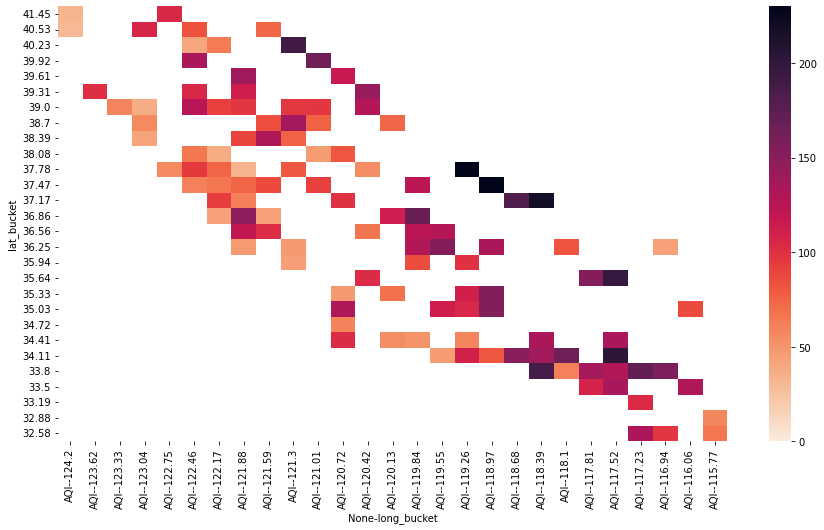

In [34]:
ca_sep = epa_data_CA_merged[epa_data_CA_merged['Month'] == 9]
heatmap_data = bucket_data(ca_sep, np.median, 30)

#create visualization
plt.figure(figsize=(15, 8))
ax = sns.heatmap(heatmap_data, vmin=0, vmax=230, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()

In [35]:
grader.check("q6b")

q6b results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 6c: Analyze Heatmap

Look up where the dark regions correspond to. Does this heatmap make sense?

<!--
BEGIN QUESTION
name: q6c
manual: True
points: 2
-->

The dark regoins are primarily in the center, where longitude is around -119 and latitude is around 37. The heatmap makes sense. It has the same shape as the shape of California. It shows that the air is more polluted around the center and east side of California, which is more distant from the ocean, compared to other regions. 

<!-- END QUESTION -->



<br/><br/>

---
## Part 3: Open-Ended EDA

Not that we have explored the data both spatially and temporally, we want to be able to look at what other indicators there are for air quality in California. Through the previous few questions we have discussed that wilfire data as well as temperature may be good indicators, but we can explitly look at correlations via the temperature to verify our hypothesis. Like temperature, there are other columns of data such as particulate matter, chemical concentrations, wind data, etc. Your open-ended EDA will be useful for filling in missing points in the heatmap that you created in question 4b. 

Your goal in this question is to find relationships between AQI and other features in the current datasets, across time and space. Your exploration can include, but is not limited to: 
- Looking at correlations between AQI and various columns of interest in `epa_data_CA`.
    - This will require some merging, which you can look at question 1 for reference. 
- Performing clustering and/or other unsupervised learning methods such as PCA to discover clusters or useful (combinations of) features in the data.
- Merging and exploring other external datasets that you may think are useful.

<!-- BEGIN QUESTION -->

### Question 7a - Code and Analysis

Please complete all of your analysis in the **single cell** below based on the prompt above.

<!--
BEGIN QUESTION
name: q7a
manual: True
points: 10
-->

In [36]:
epa_data.get('annual_county_aqi').head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10
0,Alabama,Baldwin,2020,269,250,19,0,0,0,0,74,49,36,0,0,198,0,71,0
1,Alabama,Clay,2020,108,99,9,0,0,0,0,86,49,26,0,0,0,0,108,0
2,Alabama,DeKalb,2020,364,350,14,0,0,0,0,90,45,36,0,0,331,0,33,0
3,Alabama,Elmore,2020,197,197,0,0,0,0,0,47,41,31,0,0,197,0,0,0
4,Alabama,Etowah,2020,278,260,18,0,0,0,0,92,46,34,0,0,204,0,74,0


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 7b - Visualization

Please create **two** visualizations to summarize your analysis above. The only restrictions are that these visualizations **cannot** simply be scatterplots between two features in the dataset(s) and **cannot** be of the same type (dont make two bar graphs, for example). 

<!--
BEGIN QUESTION
name: q7b
manual: True
points: 4
-->

In [37]:
epa_filenames

,name,epa_filename
0,annual_county_aqi,annual_aqi_by_county_2020
1,daily_county_aqi,daily_aqi_by_county_2020
2,daily_ozone,daily_44201_2020
3,daily_so2,daily_42401_2020
4,daily_co,daily_42101_2020
5,daily_no2,daily_42602_2020
6,daily_temp,daily_WIND_2020
7,daily_wind,daily_TEMP_2020
8,aqs_sites,aqs_sites


In [38]:
epa_data.get('daily_temp').shape, epa_data.get('daily_wind').shape
temp_data = epa_data.get('daily_wind')
temp_data[temp_data['State Name'] == 'California'][['Units of Measure', 'Event Type', 'Observation Count', 'Observation Percent', 'Arithmetic Mean','1st Max Value', '1st Max Hour', 'AQI']]
# temp_data.columns

,Units of Measure,Event Type,Observation Count,Observation Percent,Arithmetic Mean,1st Max Value,1st Max Hour,AQI
8709,Degrees Fahrenheit,None,24,100.0,44.816667,58.8,13,NaN
8710,Degrees Fahrenheit,None,24,100.0,43.483333,59.5,15,NaN
8711,Degrees Fahrenheit,None,24,100.0,43.916667,61.5,14,NaN
8712,Degrees Fahrenheit,None,22,92.0,44.500000,59.0,11,NaN
8713,Degrees Fahrenheit,None,24,100.0,45.600000,54.9,15,NaN
...,...,...,...,...,...,...,...,...
63496,Degrees Fahrenheit,None,24,100.0,47.320833,54.7,14,NaN
63497,Degrees Fahrenheit,None,24,100.0,48.129167,54.7,15,NaN
63498,Degrees Fahrenheit,None,24,100.0,48.820833,61.5,15,NaN
63499,Degrees Fahrenheit,None,24,100.0,45.341667,55.6,14,NaN


In [39]:
wind_data = epa_data.get('daily_temp')
wind_data.columns, temp_data.columns, daily_county.columns
# wind_data[wind_data['State Name'] == 'California'][['Units of Measure', 'Event Type', 'Observation Count', 'Observation Percent', 'Arithmetic Mean','1st Max Value', '1st Max Hour', 'AQI']]

(Index(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC',
        'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Sample Duration',
        'Pollutant Standard', 'Date Local', 'Units of Measure', 'Event Type',
        'Observation Count', 'Observation Percent', 'Arithmetic Mean',
        '1st Max Value', '1st Max Hour', 'AQI', 'Method Code', 'Method Name',
        'Local Site Name', 'Address', 'State Name', 'County Name', 'City Name',
        'CBSA Name', 'Date of Last Change'],
       dtype='object'),
 Index(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC',
        'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Sample Duration',
        'Pollutant Standard', 'Date Local', 'Units of Measure', 'Event Type',
        'Observation Count', 'Observation Percent', 'Arithmetic Mean',
        '1st Max Value', '1st Max Hour', 'AQI', 'Method Code', 'Method Name',
        'Local Site Name', 'Address', 'State Name', 'County Name', 'City Name',
        'CB

In [40]:
epa_data_CA_merged.head()

,State Name,county Name,Month,Day,AQI,Category,Defining Site,Latitude,Longitude
0,California,Alameda,1,1,53,Moderate,06-001-0009,37.743065,-122.169935
1,California,Alameda,1,2,43,Good,06-001-0013,37.864767,-122.302741
2,California,Alameda,1,3,74,Moderate,06-001-0013,37.864767,-122.302741
3,California,Alameda,1,4,45,Good,06-001-0007,37.687526,-121.784217
4,California,Alameda,1,5,33,Good,06-001-0007,37.687526,-121.784217


In [41]:
daily_county = epa_data.get('daily_county_aqi')
# epa_data_CA_merged.head()
daily_county.head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,Month,Day
0,Alabama,Baldwin,1,3,2020-01-01,48,Good,PM2.5,01-003-0010,1,1,1
1,Alabama,Baldwin,1,3,2020-01-04,13,Good,PM2.5,01-003-0010,1,1,4
2,Alabama,Baldwin,1,3,2020-01-07,14,Good,PM2.5,01-003-0010,1,1,7
3,Alabama,Baldwin,1,3,2020-01-10,39,Good,PM2.5,01-003-0010,1,1,10
4,Alabama,Baldwin,1,3,2020-01-13,29,Good,PM2.5,01-003-0010,1,1,13


In [42]:
# daily_ca = daily_county[daily_county["State Name"] == "California"]
# wind_ca = wind_data[wind_data["State Name"] == "California"]
# temp_ca = temp_data[temp_data["State Name"] == "California"]

# daily_wind_ca = daily_ca.merge(wind_ca,  how='left', left_on=['State Name','county Name','Date'], right_on = ['State Name','County Name','Date Local'])
# daily_wind_ca.head()
cols = ['State Name', 'county Name', 'Month', 'Day', 'AQI', 'Category', 'Defining Site', 'Latitude', 'Longitude']
aqs_sites = epa_data.get('aqs_sites')
daily_county_aqi = epa_data_CA.get('daily_county_aqi')

temp_data = epa_data.get('daily_wind')
ca_temp = temp_data[temp_data['State Name'] == 'California']
ca_temp['Year'] = pd.DatetimeIndex(ca_temp['Date Local']).year
ca_temp['Month'] = pd.DatetimeIndex(ca_temp['Date Local']).month
ca_temp['Day'] = pd.DatetimeIndex(ca_temp['Date Local']).day
ca_temp_2020 = ca_temp[ca_temp['Year']== 2020]

ca_temp_2020['State ID'] = ca_temp_2020['State Code'].astype(str).str.zfill(2)
ca_temp_2020['County ID'] = ca_temp_2020['County Code'].astype(str).str.zfill(3)
ca_temp_2020['Site ID'] = ca_temp_2020['Site Num'].astype(str).str.zfill(4)
ca_temp_2020['Defining Site'] = ca_temp_2020['State ID'] + '-' + ca_temp_2020['County ID'] + '-' + ca_temp_2020['Site ID']
ca_temp_2020 = ca_temp_2020[['Arithmetic Mean', 'Defining Site', 'Month', 'Day']] 
ca_temp_2020 = ca_temp_2020.rename(columns = {'Arithmetic Mean' : 'Temp Mean'})


wind_data = epa_data.get('daily_temp')
ca_wind = wind_data[wind_data['State Name'] == 'California']
ca_wind = ca_wind[ca_wind['Units of Measure'] == 'Knots']
ca_wind['Year'] = pd.DatetimeIndex(ca_wind['Date Local']).year
ca_wind['Month'] = pd.DatetimeIndex(ca_wind['Date Local']).month
ca_wind['Day'] = pd.DatetimeIndex(ca_wind['Date Local']).day
ca_wind_2020 = ca_wind[ca_wind['Year']== 2020]
ca_wind_2020['State ID'] = ca_wind_2020['State Code'].astype(str).str.zfill(2)
ca_wind_2020['County ID'] = ca_wind_2020['County Code'].astype(str).str.zfill(3)
ca_wind_2020['Site ID'] = ca_wind_2020['Site Num'].astype(str).str.zfill(4)
ca_wind_2020['Defining Site'] = ca_wind_2020['State ID'] + '-' + ca_wind_2020['County ID'] + '-' + ca_wind_2020['Site ID']
ca_wind_2020 = ca_wind_2020[['Arithmetic Mean', 'Defining Site', 'Month', 'Day']] 
ca_wind_2020 = ca_wind_2020.rename(columns = {'Arithmetic Mean' : 'Wind Mean'})


aqs_sites['State ID'] = aqs_sites['State Code'].astype(str).str.zfill(2)
aqs_sites['County ID'] = aqs_sites['County Code'].astype(str).str.zfill(3)
aqs_sites['Site ID'] = aqs_sites['Site Number'].astype(str).str.zfill(4)
aqs_sites['Defining Site'] = aqs_sites['State ID'] + '-' + aqs_sites['County ID'] + '-' + aqs_sites['Site ID']
aqs_sites = aqs_sites[['Latitude', 'Longitude', 'Defining Site']] 
new_df = daily_county_aqi.merge(aqs_sites,  how='left', left_on=['Defining Site'], right_on = ['Defining Site'])
epa_data_CA_merged = new_df[cols]
epa_with_temp = epa_data_CA_merged.merge(ca_temp_2020, how = 'left', left_on=['Defining Site', 'Month', 'Day'], right_on=['Defining Site', 'Month', 'Day'])
epa_temp_wind = epa_with_temp.merge(ca_wind_2020, how = 'left', left_on=['Defining Site', 'Month', 'Day'], right_on=['Defining Site', 'Month', 'Day'])

epa_2020_CA_wind_temp = epa_temp_wind[(~epa_temp_wind['Temp Mean'].isnull()) 
                                     &(~epa_temp_wind['Wind Mean'].isnull())]
epa_2020_CA_wind_temp

,State Name,county Name,Month,Day,AQI,Category,Defining Site,Latitude,Longitude,Temp Mean,Wind Mean
366,California,Amador,1,1,25,Good,06-005-0002,38.342606,-120.764426,44.816667,0.945833
367,California,Amador,1,2,18,Good,06-005-0002,38.342606,-120.764426,43.483333,0.954167
368,California,Amador,1,3,19,Good,06-005-0002,38.342606,-120.764426,43.916667,0.804167
369,California,Amador,1,8,23,Good,06-005-0002,38.342606,-120.764426,43.930435,1.213043
370,California,Amador,1,9,25,Good,06-005-0002,38.342606,-120.764426,42.416667,1.258333
...,...,...,...,...,...,...,...,...,...,...,...
19232,California,Yolo,12,27,20,Good,06-113-0004,38.534450,-121.773400,47.320833,4.966667
19233,California,Yolo,12,28,33,Good,06-113-0004,38.534450,-121.773400,48.129167,3.375000
19234,California,Yolo,12,29,28,Good,06-113-0004,38.534450,-121.773400,48.820833,5.929167
19235,California,Yolo,12,30,39,Good,06-113-0004,38.534450,-121.773400,45.341667,5.775000


In [43]:
from sklearn import linear_model as lm
api_wind_model = lm.LinearRegression(fit_intercept=True)
api_temp_model = lm.LinearRegression(fit_intercept=True)

temp_mean = epa_2020_CA_wind_temp[['Temp Mean']]
wind_mean = epa_2020_CA_wind_temp[['Wind Mean']]
aqi = epa_2020_CA_wind_temp['AQI']
api_wind_model.fit(temp_mean, aqi)
api_temp_model.fit(wind_mean, aqi)

aqi_fitted_wind = api_wind_model.predict(temp_mean)
api_fitted_temp = api_temp_model.predict(wind_mean)

api_wind_model.intercept_, api_wind_model.coef_[0]

(5.35920881426582, 0.9481896118168468)

In [44]:
api_temp_model.intercept_, api_temp_model.coef_[0]

(63.74565234007308, 0.2625160117566045)

In [ ]:
plt.scatter(aqi_fitted_wind, aqi, s=20)
plt.ylim(0, 100)
plt.title("Actual AQI vs Predicted AQI (Using Wind)")
plt.xlabel("Predicted AQI")
plt.ylabel("Actual AQI");

In [ ]:
plt.scatter(api_fitted_temp, aqi, s=20)
# plt.ylim(50, 80)
plt.title("Actual AQI vs Predicted AQI (Using Temperature)")
plt.xlabel("Predicted AQI")
plt.ylabel("Actual AQI");

In [ ]:
wind_temp = epa_2020_CA_wind_temp[['Wind Mean', 'Temp Mean']]
aqi_combined_model = lm.LinearRegression(fit_intercept=True)
aqi_combined_model.fit(wind_temp, aqi)
api_fitted_combined = aqi_combined_model.predict(wind_temp)
plt.scatter(api_fitted_combined, aqi, s=20)
plt.ylim(20, 150)
# aqi_combined_model.intercept_, aqi_combined_model.coef_
plt.title("Actual AQI vs Predicted AQI (Using Wind & Temperature)")
plt.xlabel("Predicted AQI")
plt.ylabel("Actual AQI");

In [ ]:
month = epa_2020_CA_wind_temp[['Month']]
aqi_month_model = lm.LinearRegression(fit_intercept=True)
aqi_combined_model.fit(month, aqi)
aqi_fitted_month = aqi_combined_model.predict(month)


# plt.scatter(aqi_fitted_month, aqi, s=20)

In [ ]:
cols = ['State Name', 'county Name', 'Month', 'Day', 'AQI', 'Category', 'Defining Site', 'Latitude', 'Longitude']
aqs_sites = epa_data.get('aqs_sites')
daily_county_aqi = epa_data_CA.get('daily_county_aqi')


def table_selection(df):
    result = df[df['State Name'] == 'California']
    result['Year'] = pd.DatetimeIndex(result['Date Local']).year
    result['Month'] = pd.DatetimeIndex(result['Date Local']).month
    result['Day'] = pd.DatetimeIndex(result['Date Local']).day
    result = result[result['Year']== 2020]
    result['State ID'] = result['State Code'].astype(str).str.zfill(2)
    result['County ID'] = result['County Code'].astype(str).str.zfill(3)
    result['Site ID'] = result['Site Num'].astype(str).str.zfill(4)
    result['Defining Site'] = result['State ID'] + '-' + result['County ID'] + '-' + result['Site ID']
    result = result[['Arithmetic Mean', 'Defining Site', 'Month', 'Day']]
    return result
    
temp_data = epa_data.get('daily_wind') 
temp_cleaned = table_selection(temp_data)
ca_temp_2020 = temp_cleaned.rename(columns = {'Arithmetic Mean' : 'Wind Mean'})

wind_data = epa_data.get('daily_temp')
wind_cleaned = table_selection(wind_data)
ca_wind_2020 = wind_cleaned.rename(columns = {'Arithmetic Mean' : 'Temp Mean'})

co_data = epa_data.get('daily_co')
co_cleaned = table_selection(co_data)
ca_co_2020 = co_cleaned.rename(columns = {'Arithmetic Mean' : 'co Mean'})

no2_data = epa_data.get('daily_no2')
no2_cleaned = table_selection(no2_data)
ca_no2_2020 = no2_cleaned.rename(columns = {'Arithmetic Mean' : 'no2 Mean'})

so2_data = epa_data.get('daily_so2')
so2_cleaned = table_selection(so2_data)
ca_so2_2020 = so2_cleaned.rename(columns = {'Arithmetic Mean' : 'so2 Mean'})

ozone_data = epa_data.get('daily_ozone')
ozone_cleaned = table_selection(ozone_data)
ca_ozone_2020 = ozone_cleaned.rename(columns = {'Arithmetic Mean' : 'ozone Mean'})


aqs_sites['State ID'] = aqs_sites['State Code'].astype(str).str.zfill(2)
aqs_sites['County ID'] = aqs_sites['County Code'].astype(str).str.zfill(3)
aqs_sites['Site ID'] = aqs_sites['Site Number'].astype(str).str.zfill(4)
aqs_sites['Defining Site'] = aqs_sites['State ID'] + '-' + aqs_sites['County ID'] + '-' + aqs_sites['Site ID']
aqs_sites = aqs_sites[['Latitude', 'Longitude', 'Defining Site']] 

new_df = daily_county_aqi.merge(aqs_sites,  how='left', left_on=['Defining Site'], right_on = ['Defining Site'])
epa_data_CA_merged = new_df[cols]

epa_all = epa_data_CA_merged.merge(ca_temp_2020, how = 'left', left_on=['Defining Site', 'Month', 'Day'], right_on=['Defining Site', 'Month', 'Day']).merge(
    ca_wind_2020, how = 'left', left_on=['Defining Site', 'Month', 'Day'], right_on=['Defining Site', 'Month', 'Day']).merge(
    ca_co_2020, how = 'left', left_on=['Defining Site', 'Month', 'Day'], right_on=['Defining Site', 'Month', 'Day']).merge(
    ca_no2_2020, how = 'left', left_on=['Defining Site', 'Month', 'Day'], right_on=['Defining Site', 'Month', 'Day']).merge(
    ca_so2_2020, how = 'left', left_on=['Defining Site', 'Month', 'Day'], right_on=['Defining Site', 'Month', 'Day']).merge(
    ca_ozone_2020, how = 'left', left_on=['Defining Site', 'Month', 'Day'], right_on=['Defining Site', 'Month', 'Day'])

epa_all = epa_all[(~epa_all['Temp Mean'].isnull())
                 &(~epa_all['Wind Mean'].isnull())
                 &(~epa_all['co Mean'].isnull())
                 &(~epa_all['no2 Mean'].isnull())
                  &(~epa_all['so2 Mean'].isnull())
                 &(~epa_all['ozone Mean'].isnull())]

epa_all

In [ ]:
import seaborn as sns
temp = epa_2020_CA_wind_temp.copy()
temp = temp[(temp['AQI'] <=300) & (temp['AQI'] >= 15)]
# temp.boxplot(column = 'AQI', by='Month');
sns.boxplot(x = 'Month', y='AQI', data = temp)
plt.title('AQI vs Month');

In [ ]:
temp_groups = np.arange(15, 120, 3)
length = len(temp['AQI'])
result = [0] * length
for i in range(length):
    for val in temp_groups:
        if temp['Temp Mean'].iloc[i] >= val:
            result[i] = val
temp['temp_group'] = result
temp_group_count = temp.groupby('temp_group').agg(np.mean)
# temp_group_count

In [ ]:
sns.lineplot(x = 'temp_group', y='AQI', data = temp_group_count, markers=False);
plt.title("AQI vs Temperature")
plt.ylabel("Average AQI")
plt.xlabel("Temperature (F)");

In [ ]:
wind_groups = np.arange(0, 25, 1)
length = len(temp['AQI'])
result = [0] * length
for i in range(length):
    for val in wind_groups:
        if temp['Wind Mean'].iloc[i] >= val:
            result[i] = val
temp['wind_group'] = result
wind_group_count = temp.groupby('wind_group').agg(np.mean)

In [ ]:
sns.lineplot(x = 'wind_group', y='AQI', data = wind_group_count, markers=False);
plt.title("AQI vs Wind Speed")
plt.ylabel("Average AQI")
plt.xlabel("Wind Speed (Knots)");

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 7c - Summary

In a paragraph, summarize the your findings and visualizations and explain how they will be useful for predicting AQI. Make sure that your answer is thoughtful and detailed in that it describes what you did and how you reached your conclusion. 

<!--
BEGIN QUESTION
name: q7c
manual: True
points: 4
-->

According to our box plot. The median AQI is generally low from March to June--about 35, though there are occasionally some outliers. For the rest of the year, the median AQI is relatively high, ranging from 50 to over 100. Then we attempt to visualize the relationship between wind and AQI. We used linear regression to model wind and AQI and found that there is a weak negative relationship between wind and AQI. The slope and intercept of our linear regression line is -0.00354 and 68.64432747071004. Next, we used both wind and temperature to model AQI. The coefficients are 1.27507759, -0.00799342, and the intercept is -9.754801085428369.  We discovered a positive correlation between temperature and AQI and a negative correlation between wind and AQI. Therefore, our model suggests that the higher the temperature is, the higher AQI is, and the lower the strength of wind, the higher AQI is (the air is more polluted), which is helpful when predicting AQI. After modeling the data with linear regression, we also used line plots to visualize the correlation found utilizing linear regression. The first line plot visualizes relationship between temperature and AQI. The x-axis is temperature, which ranges from 15 Fahrenheit to 120 Fahrenheit and increases by 3 Fahrenheit each time; the y-axis is the mean AQI of every specific temperature. Although the mean AQI fluctuates as temperature increases, we can see that the mean AQI increases as temperature increases. The second line plot visualizes relationship between wind and AQI. The x-axis is the strength of wind, which ranges from 0 to 25 Knots; the y-axis is the mean AQI of every specific wind strength.

<!-- END QUESTION -->

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export()